In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import sklearn
from datetime import datetime
import random
import math

import warnings
warnings.filterwarnings('ignore')

In [8]:
df_w = pd.read_csv('Data\\weather_train.csv')

df_w['month'] = pd.DatetimeIndex(df_w['timestamp']).month.astype(str)
df_w['day'] = pd.DatetimeIndex(df_w['timestamp']).day

df_w['site_id'] = df_w['site_id'].astype(str)

df_w.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,1,1
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,1,1
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,1,1
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028BDC2F8188>,
      dtype=object)

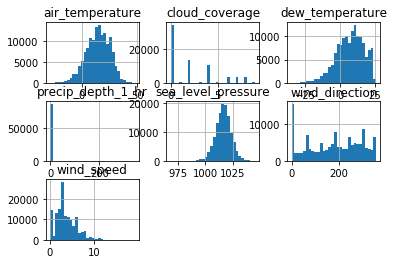

In [9]:
df_w[['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']].hist(bins=30)

In [10]:
print("Column-wise missing value percentage")
print(df_w.isnull().sum()/len(df_w)*100)

Column-wise missing value percentage
site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
cloud_coverage        49.489529
dew_temperature        0.080845
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
month                  0.000000
day                    0.000000
dtype: float64


In [11]:
#get missing values %s for each meteorological site
def nan_ratio(se):
    return(100*np.sum(se.isnull())/len(se))

df_w.groupby(by=['site_id'])['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'].agg(nan_ratio)

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,
0,0.034153,43.602004,0.034153,0.011384,0.967668,2.846084,0.000000
1,0.011412,80.588839,0.011412,100.000000,0.593404,0.034235,0.000000
10,0.273286,27.897973,0.307447,0.307447,1.605557,6.080619,1.184240
11,0.000000,100.000000,0.267007,91.513815,0.092872,0.000000,0.000000
12,0.000000,0.673901,0.000000,100.000000,0.639634,0.011422,0.000000
13,0.011386,48.935443,0.011386,0.136628,1.366276,2.470682,0.011386
14,0.011393,37.723596,0.011393,0.353196,1.253276,3.304090,0.262049
15,0.000000,52.034540,0.035486,79.855690,6.020819,2.862550,0.331204
2,0.011386,26.801776,0.011386,0.751452,0.500968,6.728908,0.056928


In [12]:
df_w.groupby(by=['site_id'])['site_id'].count()

site_id
0     8784
1     8763
10    8782
11    8614
12    8755
13    8783
14    8777
15    8454
2     8783
3     8780
4     8783
5     8755
6     8782
7     8614
8     8784
9     8780
Name: site_id, dtype: int64

In [13]:
df_w = df_w.sort_values(by=['site_id', 'timestamp'])

In [14]:
#randomly fill values of series with NaN
def randnan(s, p_fill):
    
    p = s.copy(deep=True)
    
    for i in range(len(s)):
        x = random.randint(0,99)
        if(x<p_fill):
            p.iloc[i] = np.nan
    
    return p


In [15]:
#try combinations of interpolations, create cross-validation sets, choose best methods for each feature
def Missing_Val_Imputation(df, iterations=10, nan_percent = 5):
    
    methods = ['linear', 'quadratic', 'nearest', 'mean', 'zeros']
    second_methods = ['mean', 'zeros', 'nearest', 'median']
    
    actual = df[df.columns[1]].dropna()
    hold_error = actual.max() - actual.min()
    
    error_rmse = hold_error
    method = ''
    second_method = ''
    
    
    
    for i in methods:
        for j in second_methods:
            
            error_sum_rmse = 0
            error_sum_mae = 0
            
            for k in range(iterations):
                
                predicted = pd.Series()
                
                for l in range(16):
                    
                    s = df[df['site_id']==l][df.columns[1]]
                    s_nans = s.copy(deep=True).dropna()
                    
                    s_mean = s_nans.mean()
                    s_median = s_nans.median()
                    
                    s_sim = randnan(s_nans, nan_percent)

                    if(i=='zeros'):
                        s_sim = s_sim.fillna(0)
                    elif(i=='mean'):
                        s_sim = s_sim.fillna(s_mean)
                    else:
                        s_sim = s_sim.interpolate(method=i, limit_dirction='both')

                    if(j=='mean'):
                        s_sim = s_sim.fillna(s_mean)
                    elif(j=='zeros'):
                        s_sim = s_sim.fillna(0)
                    elif(j=='median'):
                        s_sim = s_sim.fillna(s_median)
                    else:
                        s_sim = s_sim.interpolate(method='nearest', limit_direction='both')
                    
                    predicted = pd.concat([predicted, s_sim])
                
                
                dfh = pd.DataFrame({'Actual': actual, 'Prediction': predicted})
                x = dfh[dfh['Actual']!=dfh['Prediction']]
                error_sum_rmse += (((x['Actual']-x['Prediction'])**2).sum()/len(x))**.5
                error_sum_mae += (abs(x['Actual']-x['Prediction'])).sum()/len(x)
                
            if(error_sum_rmse/iterations<error_rmse):
                error_rmse = error_sum_rmse/iterations
                error_mae = error_sum_mae/iterations
                method = i
                second_method = j
    
    return method, second_method, error_rmse, error_mae



In [16]:
feature_cols = ['air_temperature', 'dew_temperature', 'sea_level_pressure', 'wind_speed']
missing_percent = [1,1,8,5,1]


method = []
second_method = []
rmse = []
mae = []
means = []
medians = []
stdevs = []



for i in range(len(feature_cols)):
    hold = Missing_Val_Imputation(df_w[['site_id', feature_cols[i]]], iterations=10, nan_percent=missing_percent[i])
    method.append(hold[0])
    second_method.append(hold[1])
    rmse.append(hold[2])
    mae.append(hold[3])
    means.append(df_w[feature_cols[i]].mean())
    medians.append(df_w[feature_cols[i]].median())
    stdevs.append(df_w[feature_cols[i]].std())
    
df_Interpolation = pd.DataFrame({'Feature': feature_cols, 'Method': method, 
                                 'Second Order': second_method, 'RMSE': rmse, 
                                 'MAE': mae, 'Mean': means,
                                 'Median': medians, 'St. Dev': stdevs})

In [17]:
df_Interpolation

,Feature,Method,Second Order,RMSE,MAE,Mean,Median,St. Dev
0,air_temperature,linear,mean,0.0,0.0,14.418106,15.0,10.626595
1,dew_temperature,linear,mean,0.0,0.0,7.350158,8.3,9.790235
2,sea_level_pressure,linear,mean,0.0,0.0,1016.158038,1016.4,7.629684
3,wind_speed,linear,mean,0.0,0.0,3.560527,3.1,2.335874


In [18]:
#apply interpolations, transforms
df_w2 = df_w.copy(deep=True)

df_w2['air_temperature'] = df_w2['air_temperature'].interpolate(method='quadratic', limit_direction='both')
df_w2['air_temperature'] = df_w2['air_temperature'].interpolate(method='nearest', limit_direction='both')

df_w2['dew_temperature'] = df_w2['dew_temperature'].interpolate(method='linear', limit_direction='both')
df_w2['dew_temperature'] = df_w2['dew_temperature'].interpolate(method='nearest', limit_direction='both')

df_w2['sea_level_pressure'] = df_w2['sea_level_pressure'].interpolate(method='quadratic', limit_direction='both')
df_w2['sea_level_pressure'] = df_w2['sea_level_pressure'].interpolate(method='nearest', limit_direction='both')
df_w2['sea_level_pressure'] = np.where((df_w2['site_id']==5), np.nan, df_w2['sea_level_pressure'])

df_w2['wind_speed'] = df_w2['wind_speed'].interpolate(method='linear', limit_direction='both')
df_w2['wind_speed'] = df_w2['wind_speed'].interpolate(method='nearest', limit_direction='both')


#Create categorical variable for wind direction
df_w2['wind_direction cat'] = np.where(df_w2['wind_direction'].isna(), 'Unknown',
                                  np.where(df_w2['wind_speed']==0, 'No Wind',
                                  np.where((df_w2['wind_direction']<22.5)  | (df_w2['wind_direction']>=337.5), 'East',
                                  np.where((df_w2['wind_direction']<67.5)  & (df_w2['wind_direction']>=22.5), 'Northeast',
                                  np.where((df_w2['wind_direction']<112.5) & (df_w2['wind_direction']>=67.5), 'North',
                                  np.where((df_w2['wind_direction']<157.5) & (df_w2['wind_direction']>=112.5), 'Northwest',
                                  np.where((df_w2['wind_direction']<202.5) & (df_w2['wind_direction']>=157.5), 'West',
                                  np.where((df_w2['wind_direction']<247.5) & (df_w2['wind_direction']>=202.5), 'Southwest',
                                  np.where((df_w2['wind_direction']<292.5) & (df_w2['wind_direction']>=247.5), 'South', 
                                  'Southeast')))))))))

#Create second categorical variable for wind direction, shifted 22.5 degrees
df_w2['wind_direction cat2'] = np.where(df_w2['wind_direction'].isna(), 'Unknown',
                                  np.where(df_w2['wind_speed']==0, 'No Wind',
                                  np.where((df_w2['wind_direction']<45)  & (df_w2['wind_direction']>=0), 'East',
                                  np.where((df_w2['wind_direction']<90)  & (df_w2['wind_direction']>=45), 'Northeast',
                                  np.where((df_w2['wind_direction']<135) & (df_w2['wind_direction']>=90), 'North',
                                  np.where((df_w2['wind_direction']<180) & (df_w2['wind_direction']>=135), 'Northwest',
                                  np.where((df_w2['wind_direction']<225) & (df_w2['wind_direction']>=180), 'West',
                                  np.where((df_w2['wind_direction']<270) & (df_w2['wind_direction']>=225), 'Southwest',
                                  np.where((df_w2['wind_direction']<315) & (df_w2['wind_direction']>=270), 'South', 
                                  'Southeast')))))))))

In [19]:
#new missing values %s
df_w2.groupby(by=['site_id'])['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed',].agg(nan_ratio)

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,
0,0.0,43.602004,0.0,0.011384,0.0,2.846084,0.0
1,0.0,80.588839,0.0,100.000000,0.0,0.034235,0.0
10,0.0,27.897973,0.0,0.307447,0.0,6.080619,0.0
11,0.0,100.000000,0.0,91.513815,0.0,0.000000,0.0
12,0.0,0.673901,0.0,100.000000,0.0,0.011422,0.0
13,0.0,48.935443,0.0,0.136628,0.0,2.470682,0.0
14,0.0,37.723596,0.0,0.353196,0.0,3.304090,0.0
15,0.0,52.034540,0.0,79.855690,0.0,2.862550,0.0
2,0.0,26.801776,0.0,0.751452,0.0,6.728908,0.0


In [303]:
df_w2.describe()

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day
count,139773.000000,70600.000000,139773.000000,89484.000000,139773.000000,133505.000000,139773.000000,139773.000000
mean,14.417923,2.149306,7.347901,0.983047,997.516364,180.526632,3.559284,15.771043
std,10.626071,2.599150,9.788823,8.463678,86.560349,111.523629,2.334483,8.809815
min,-28.900000,0.000000,-35.000000,-1.000000,453.781387,0.000000,0.000000,1.000000
25%,7.200000,0.000000,0.600000,0.000000,1010.500000,80.000000,2.100000,8.000000
50%,15.000000,2.000000,8.300000,0.000000,1015.800000,190.000000,3.100000,16.000000
75%,22.200000,4.000000,14.400000,0.000000,1020.400000,280.000000,5.000000,23.000000
max,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000,31.000000


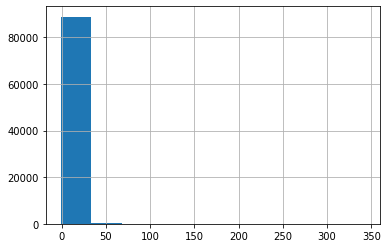

In [20]:
df_w2['precip_depth_1_hr'].hist()

In [21]:
hold = df_w2.groupby('cloud_coverage')['cloud_coverage'].count()

hold/hold.sum()

cloud_coverage
0.0    0.479759
1.0    0.010099
2.0    0.192422
3.0    0.008612
4.0    0.145057
5.0    0.007450
6.0    0.049873
7.0    0.049363
8.0    0.050014
9.0    0.007351
Name: cloud_coverage, dtype: float64

In [22]:
100*len(df_w2[df_w2['precip_depth_1_hr']<=0])/len(df_w2[~df_w2['precip_depth_1_hr'].isna()])

93.52509945912118

In [23]:
df_w2['precipitation'] = np.where(df_w2['precip_depth_1_hr'].isna(), 'Unknown', 
                                  np.where(df_w2['precip_depth_1_hr']<=0, 'N', 'Y'))

df_w2['precipitation sign'] = np.where(df_w2['precip_depth_1_hr'].isna(), 'Unknown',
                                   np.where(df_w2['precip_depth_1_hr']<0, 'Negative',
                                   np.where(df_w2['precip_depth_1_hr']==0, 'Zero', 'Positive')))

In [24]:
df_w2.groupby('cloud_coverage')['air_temperature'].count()

cloud_coverage
0.0    33871
1.0      713
2.0    13585
3.0      608
4.0    10241
5.0      526
6.0     3521
7.0     3485
8.0     3531
9.0      519
Name: air_temperature, dtype: int64

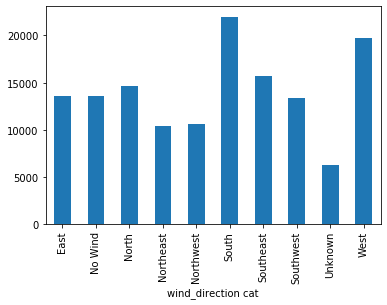

In [25]:
df_w2.groupby('wind_direction cat')['air_temperature'].count().plot.bar()

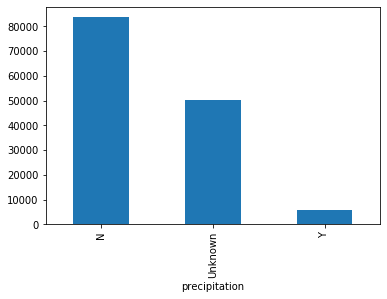

In [26]:
df_w2.groupby('precipitation')['air_temperature'].count().plot.bar()

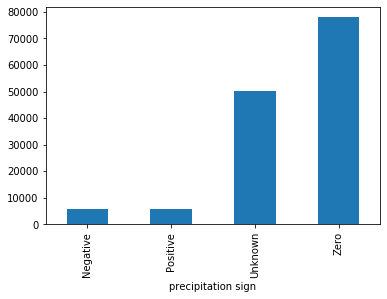

In [27]:
df_w2.groupby('precipitation sign')['air_temperature'].count().plot.bar()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028BDE529AC8>,
      dtype=object)

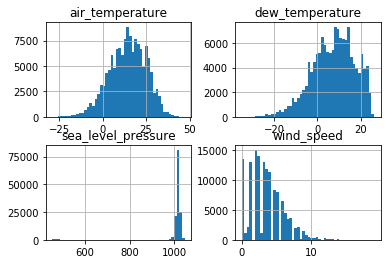

In [28]:
df_w2[['air_temperature', 'dew_temperature', 'sea_level_pressure', 'wind_speed']].hist(bins=50)

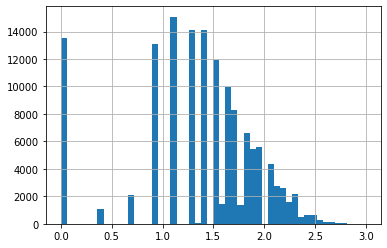

In [29]:
df_w2['wind_speed_log'] = np.log(df_w2['wind_speed']+1)

df_w2['wind_speed_log'].hist(bins=50)

In [30]:
df_w2.describe()

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day,wind_speed_log
count,139773.000000,70600.000000,139773.000000,89484.000000,139773.000000,133505.000000,139773.000000,139773.000000,139773.000000
mean,14.417923,2.149306,7.347901,0.983047,997.516364,180.526632,3.559284,15.771043,1.365294
std,10.626071,2.599150,9.788823,8.463678,86.560349,111.523629,2.334483,8.809815,0.595006
min,-28.900000,0.000000,-35.000000,-1.000000,453.781387,0.000000,0.000000,1.000000,0.000000
25%,7.200000,0.000000,0.600000,0.000000,1010.500000,80.000000,2.100000,8.000000,1.131402
50%,15.000000,2.000000,8.300000,0.000000,1015.800000,190.000000,3.100000,16.000000,1.410987
75%,22.200000,4.000000,14.400000,0.000000,1020.400000,280.000000,5.000000,23.000000,1.791759
max,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000,31.000000,2.995732


In [31]:
corr = df_w2[['air_temperature', 'dew_temperature', 'sea_level_pressure', 'wind_speed', 'wind_speed_log', 'precip_depth_1_hr']].corr()
corr.style.background_gradient(cmap='coolwarm')

,air_temperature,dew_temperature,sea_level_pressure,wind_speed,wind_speed_log,precip_depth_1_hr
air_temperature,1,0.790371,0.00737667,-0.0570288,-0.0340783,-0.0104807
dew_temperature,0.790371,1,-0.0816178,-0.0968902,-0.0855019,0.0659108
sea_level_pressure,0.00737667,-0.0816178,1,-0.119393,-0.121449,-0.0808626
wind_speed,-0.0570288,-0.0968902,-0.119393,1,0.927081,0.0351966
wind_speed_log,-0.0340783,-0.0855019,-0.121449,0.927081,1,0.0328514
precip_depth_1_hr,-0.0104807,0.0659108,-0.0808626,0.0351966,0.0328514,1


In [32]:
def minmax(s):
    
    s = (s-min(s.dropna()))/(max(s.dropna())-min(s.dropna()))
    
    return s


In [33]:
df_w2.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,wind_direction cat,wind_direction cat2,precipitation,precipitation sign,wind_speed_log
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,No Wind,No Wind,Unknown,Unknown,0.000000
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,1,1,North,Northeast,N,Negative,0.916291
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,1,1,No Wind,No Wind,N,Zero,0.000000
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,1,1,No Wind,No Wind,N,Zero,0.000000
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,1,1,South,Southwest,N,Negative,1.280934


In [34]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression

le = preprocessing.LabelEncoder()

dataset = df_w2.dropna()
dataset['cloudy'] = np.where(dataset['cloud_coverage']<2, 'Not Cloudy', 'Cloudy')
dataset = dataset.drop(['cloud_coverage'], axis=1)


df_train = dataset.sample(frac=0.8,random_state=11)
df_test = dataset.drop(df_train.index)





# Transfomer for performing one hot encoding on a specified categorical column
class OneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self,col):
        self.col = col
                
    def transform(self, X):
        return pd.get_dummies(X[self.col]) 

    def fit(self, X, y=None):
        return self  
    
# Stateless transformer for selecting a specified columns
class DFSubsetSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self,cols):
        self.cols = cols
        
    def transform(self ,X):
        return X[self.cols]
    
    def fit(self, X, y=None):
        return self
    
class ConcatFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self,cols,sep="_"):
        self.cols = cols
        self.sep = sep
                
    def transform(self, X):
        concat_col = self.sep.join(self.cols)
        return X.apply(lambda x : self.sep.join([x[col] for col in self.cols]) ,axis=1).to_frame(name = concat_col)

    def fit(self, X, y=None):
        return self  

    
class MinMaxTransform(BaseEstimator, TransformerMixin):

    def __init__(self, cols=None):
        self = self
       
    def transform(self, X):
        
        for col in X:
            X[col] = (X[col]-min(X[col].dropna()))/(max(X[col].dropna())-min(X[col].dropna()))
        return X

    def fit(self, X, y=None):
        return self


In [35]:
df_trainx = df_train.drop('cloudy', axis=1)
df_trainy = df_train['cloudy']

df_testx = df_test.drop('cloudy', axis=1)
df_testy = df_test['cloudy']

categorical_features = ['wind_direction cat', 'wind_direction cat2', 
                        'month', 'precipitation', 'precipitation sign',]

numeric_features = ['air_temperature', 'dew_temperature', 
                    'sea_level_pressure', 'wind_speed', 
                    'wind_speed_log', 'day', 
                    'precip_depth_1_hr']


categorical_transformer = Pipeline(steps=[('cat_selector', DFSubsetSelector(categorical_features)),
                                          ('one_hot_encoder', OneHotEncoder(categorical_features))])

numerical_transformer = Pipeline(steps=[('cat_selector', DFSubsetSelector(numeric_features)),
                                        ('minmax', MinMaxTransform(numeric_features))])
    
    
full_transform = FeatureUnion(transformer_list = [('categorical_transformer', categorical_transformer),
                                                  ('numerical_pipeline', numerical_transformer)])

full_pipeline = Pipeline(steps=[('full_transform', full_transform),
                                ('model', MLPClassifier())])



In [36]:

hidden = [100, 150, 200]
activ = ['logistic', 'tanh', 'relu']
optim = ['lbfgs', 'adam', 'sgd']


for i in hidden:
    for j in activ:
        for k in optim:
            classifier = MLPClassifier(hidden_layer_sizes=(i,), activation = j, solver = k)
            pipeline = Pipeline(steps=[('full_transform', full_transform), 
                                       ('model', classifier)])
            
            pipeline.fit(df_trainx, df_trainy)
            y_pred_ = pipeline.predict(df_testx) 
            rmse = accuracy_score(y_pred_, df_testy)
            
            print(rmse)
            #result_table = result_table.append({'r': regressor, 'rmse': rmse})16

0.7022362912284285
0.6944756458694986
0.6898805269069743
0.7160216481160012
0.713979373021546
0.6990707648320229
0.7267435923618911
0.730623915041356
0.7035637700398244
0.7034616562851016
0.6975390585111815
0.6912080057183703
0.7147962830593281
0.7113244153987542
0.6999897886245278
0.730623915041356
0.7380782191361176
0.7042785663228837
0.7032574287756561
0.6974369447564587
0.6898805269069743
0.7141836005309915
0.7125497804554274
0.6948841008883897
0.7283774124374554
0.7347084652302666
0.7070356377003982


In [37]:
mul_lr = LogisticRegression(class_weight='balanced')
pipeline = Pipeline(steps=[('full_transform', full_transform), ('model', classifier)])

pipeline.fit(df_trainx, df_trainy)
y_pred_ = pipeline.predict(df_testx)
print(accuracy_score(y_pred_, df_testy))

0.7068314101909527


In [38]:
hold = dataset.groupby('cloudy')['cloudy'].count()
hold/hold.sum()

cloudy
Cloudy        0.502297
Not Cloudy    0.497703
Name: cloudy, dtype: float64

In [44]:
#manipulate test  
df_wt = pd.read_csv('Data\\weather_test.csv')

df_wt['month'] = pd.DatetimeIndex(df_wt['timestamp']).month.astype(str)
df_wt['day'] = pd.DatetimeIndex(df_wt['timestamp']).day
df_wt['site_id'] = df_wt['site_id'].astype(str)

df_wt2 = df_wt.copy(deep=True)

df_wt2['air_temperature'] = df_wt2['air_temperature'].interpolate(method='quadratic', limit_direction='both')
df_wt2['air_temperature'] = df_wt2['air_temperature'].interpolate(method='nearest', limit_direction='both')

df_wt2['dew_temperature'] = df_wt2['dew_temperature'].interpolate(method='linear', limit_direction='both')
df_wt2['dew_temperature'] = df_wt2['dew_temperature'].interpolate(method='nearest', limit_direction='both')

df_wt2['sea_level_pressure'] = df_wt2['sea_level_pressure'].interpolate(method='quadratic', limit_direction='both')
df_wt2['sea_level_pressure'] = df_wt2['sea_level_pressure'].interpolate(method='nearest', limit_direction='both')
df_wt2['sea_level_pressure'] = np.where((df_wt2['site_id']==5), np.nan, df_wt2['sea_level_pressure'])

df_wt2['wind_speed'] = df_wt2['wind_speed'].interpolate(method='linear', limit_direction='both')
df_wt2['wind_speed'] = df_wt2['wind_speed'].interpolate(method='nearest', limit_direction='both')


df_wt2['wind_direction cat'] = np.where(df_wt2['wind_direction'].isna(), 'Unknown',
                                  np.where(df_wt2['wind_speed']==0, 'No Wind',
                                  np.where((df_wt2['wind_direction']<22.5)  | (df_wt2['wind_direction']>=337.5), 'East',
                                  np.where((df_wt2['wind_direction']<67.5)  & (df_wt2['wind_direction']>=22.5), 'Northeast',
                                  np.where((df_wt2['wind_direction']<112.5) & (df_wt2['wind_direction']>=67.5), 'North',
                                  np.where((df_wt2['wind_direction']<157.5) & (df_wt2['wind_direction']>=112.5), 'Northwest',
                                  np.where((df_wt2['wind_direction']<202.5) & (df_wt2['wind_direction']>=157.5), 'West',
                                  np.where((df_wt2['wind_direction']<247.5) & (df_wt2['wind_direction']>=202.5), 'Southwest',
                                  np.where((df_wt2['wind_direction']<292.5) & (df_wt2['wind_direction']>=247.5), 'South', 
                                  'Southeast')))))))))
df_wt2['wind_direction cat2'] = np.where(df_wt2['wind_direction'].isna(), 'Unknown',
                                  np.where(df_wt2['wind_speed']==0, 'No Wind',
                                  np.where((df_wt2['wind_direction']<45)  & (df_wt2['wind_direction']>=0), 'East',
                                  np.where((df_wt2['wind_direction']<90)  & (df_wt2['wind_direction']>=45), 'Northeast',
                                  np.where((df_wt2['wind_direction']<135) & (df_wt2['wind_direction']>=90), 'North',
                                  np.where((df_wt2['wind_direction']<180) & (df_wt2['wind_direction']>=135), 'Northwest',
                                  np.where((df_wt2['wind_direction']<225) & (df_wt2['wind_direction']>=180), 'West',
                                  np.where((df_wt2['wind_direction']<270) & (df_wt2['wind_direction']>=225), 'Southwest',
                                  np.where((df_wt2['wind_direction']<315) & (df_wt2['wind_direction']>=270), 'South', 
                                  'Southeast')))))))))

df_wt2['precipitation'] = np.where(df_wt2['precip_depth_1_hr'].isna(), 'Unknown', 
                                  np.where(df_wt2['precip_depth_1_hr']<=0, 'N', 'Y'))

df_wt2['precipitation sign'] = np.where(df_wt2['precip_depth_1_hr'].isna(), 'Unknown',
                                   np.where(df_wt2['precip_depth_1_hr']<0, 'Negative',
                                   np.where(df_wt2['precip_depth_1_hr']==0, 'Zero', 'Positive')))

df_wt2['wind_speed_log'] = np.log(df_wt2['wind_speed']+1)

In [45]:
x = df_wt2.columns.values
df_wt2.groupby('site_id')[x].agg(nan_ratio)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,wind_direction cat,wind_direction cat2,precipitation,precipitation sign,wind_speed_log
site_id,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,43.053653,0.0,0.171233,0.0,2.722603,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,79.094117,0.0,100.000000,0.0,0.028923,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,29.068437,0.0,0.217441,0.0,5.985351,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,100.000000,0.0,89.157063,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.324093,0.0,100.000000,0.0,0.017362,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,50.202637,0.0,3.099492,0.0,2.602888,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,44.553551,0.0,0.565198,0.0,2.728934,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,57.926865,0.0,75.780478,0.0,2.505668,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,31.078767,0.0,0.119863,0.0,6.809361,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [46]:
df_w2.to_csv('Data\\weather_train_processed.csv', index=False)
df_wt2.to_csv('Data\\weather_test_processed.csv', index=False)